# Transfer Learning

- This notebook shows how to use one fitted model stored in a `Forecaster` object to make predictions on a separate time series.
- Requires `>=0.19.0`
- As of `0.19.1`, univariate sklearn and tensorflow (RNN/LSTM) models are supported for this type of process. Multivariate sklearn, then the rest of the model types will be worked on next.
- See the [documentation](https://scalecast.readthedocs.io/en/latest/Forecaster/Forecaster.html#src.scalecast.Forecaster.Forecaster.transfer_predict).

In [1]:
from scalecast.Forecaster import Forecaster
from scalecast.util import infer_apply_Xvar_selection, find_optimal_transformation
from scalecast.Pipeline import Pipeline, Transformer, Reverter
from scalecast import GridGenerator
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
GridGenerator.get_example_grids()

## Initiate the First Forecaster Object

This series ends December, 2020.

In [3]:
df = pdr.get_data_fred(
    'HOUSTNSA',
    start = '1959-01-01',
    end = '2020-12-31',
)

df.tail()

,HOUSTNSA
DATE,
2020-08-01,122.5
2020-09-01,126.3
2020-10-01,131.2
2020-11-01,117.8
2020-12-01,115.1


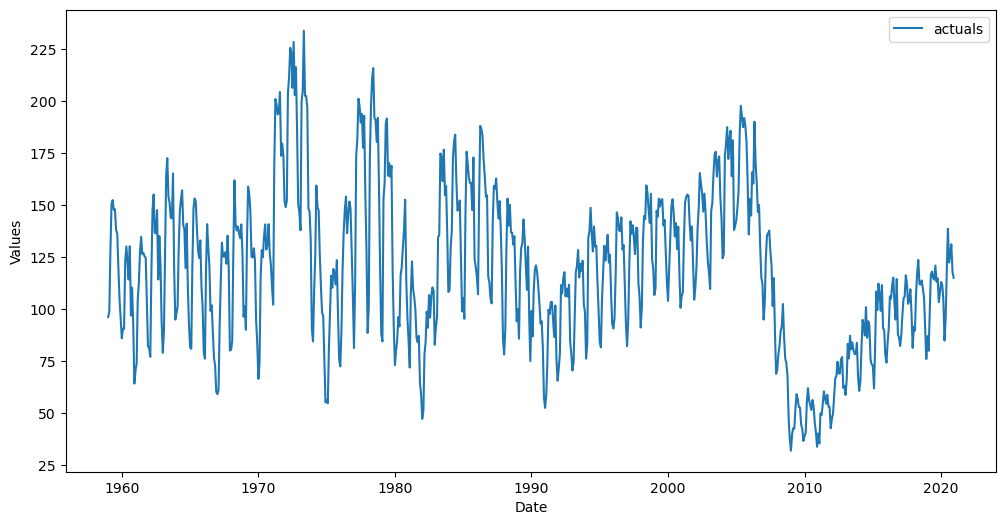

In [4]:
f = Forecaster(
    y = df.iloc[:,0],
    current_dates = df.index,
    future_dates = 24,
)

f.plot()
plt.show()

### Automatically add Xvars to the object

In [5]:
f.auto_Xvar_select()
f

Forecaster(
    DateStartActuals=1959-01-01T00:00:00.000000000
    DateEndActuals=2020-12-01T00:00:00.000000000
    Freq=MS
    N_actuals=744
    ForecastLength=24
    Xvars=['AR1', 'AR2', 'AR3', 'AR4']
    TestLength=0
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=None
    CurrentEstimator=mlr
    GridsFile=Grids
)

### Fit an XGBoost Model and Make Predictions

In [6]:
f.set_estimator('xgboost')
f.ingest_grid('xgboost')
f.limit_grid_size(10)
f.cross_validate(k=3,test_length=48)
f.auto_forecast()

### View the Forecast

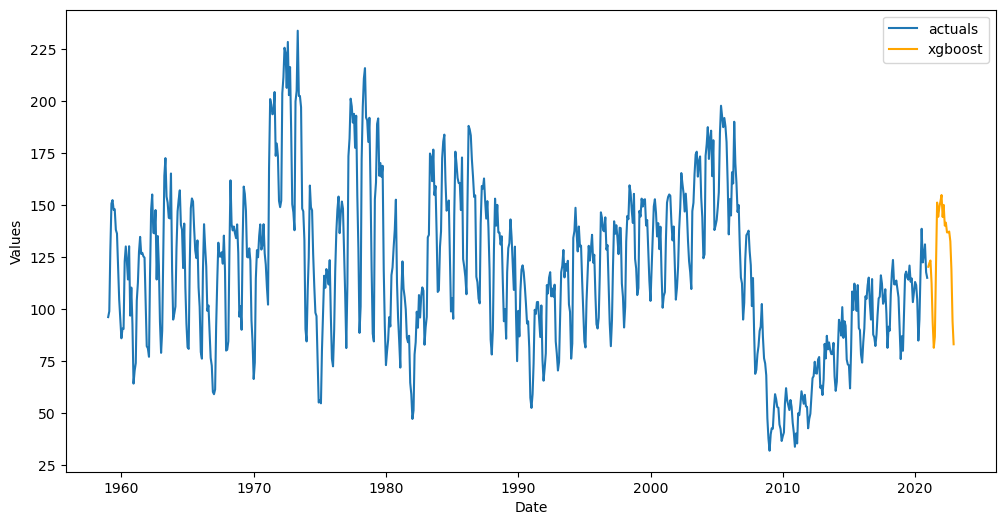

In [7]:
f.plot()
plt.show()

## Initiate the Second Forecaster Object

- Later, if we have more data streaming in, instead of refitting a model, we can use the already-fitted model to make the predictions. This updated series is through June, 2023
- You can use an updated version of the original series, you can use the same series with an extended Forecast horizon, or you can use an entirely different series (as long as it's the same frequency) to perform this process

In [8]:
df_new = pdr.get_data_fred(
    'HOUSTNSA',
    start = '1959-01-01',
    end = '2023-06-30',
)

df_new.tail()

,HOUSTNSA
DATE,
2023-02-01,103.2
2023-03-01,114.0
2023-04-01,121.7
2023-05-01,146.0
2023-06-01,132.6


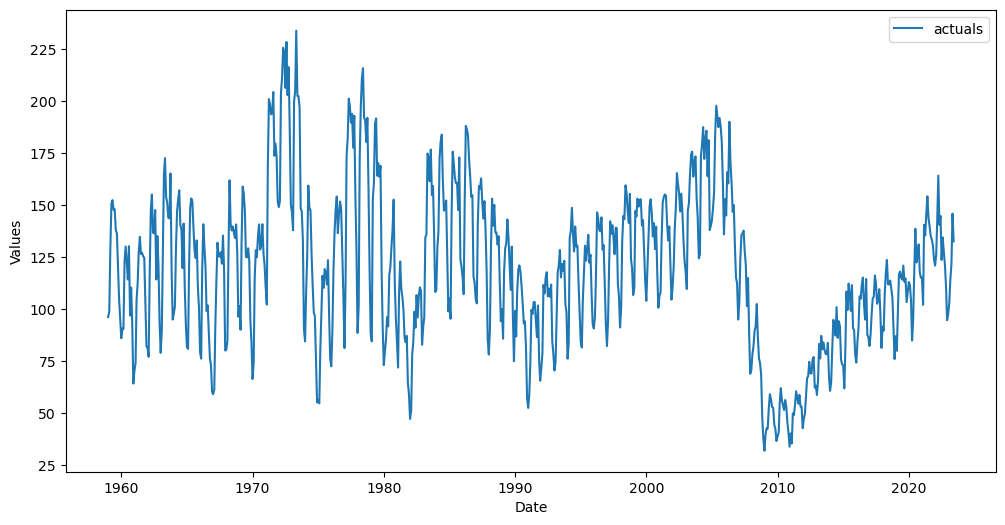

In [9]:
f_new = Forecaster(
    y = df_new.iloc[:,0],
    current_dates = df_new.index,
    future_dates = 48,
)

f_new.plot()
plt.show()

### Add the same Xvars to the new Forecaster object
- The helper function below can assist when you automatically added Xvars
- If you manually added Xvars, you can wrap the selection process in a function and run this new `Forecaster` object through the same function.

In [10]:
f_new = infer_apply_Xvar_selection(infer_from=f,apply_to=f_new)
f_new

Forecaster(
    DateStartActuals=1959-01-01T00:00:00.000000000
    DateEndActuals=2023-06-01T00:00:00.000000000
    Freq=MS
    N_actuals=774
    ForecastLength=48
    Xvars=['AR1', 'AR2', 'AR3', 'AR4']
    TestLength=0
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=None
    CurrentEstimator=mlr
    GridsFile=Grids
)

### Apply fitted model from first object onto this new object

In [11]:
f_new.transfer_predict(transfer_from=f,model='xgboost')

### View the new forecast

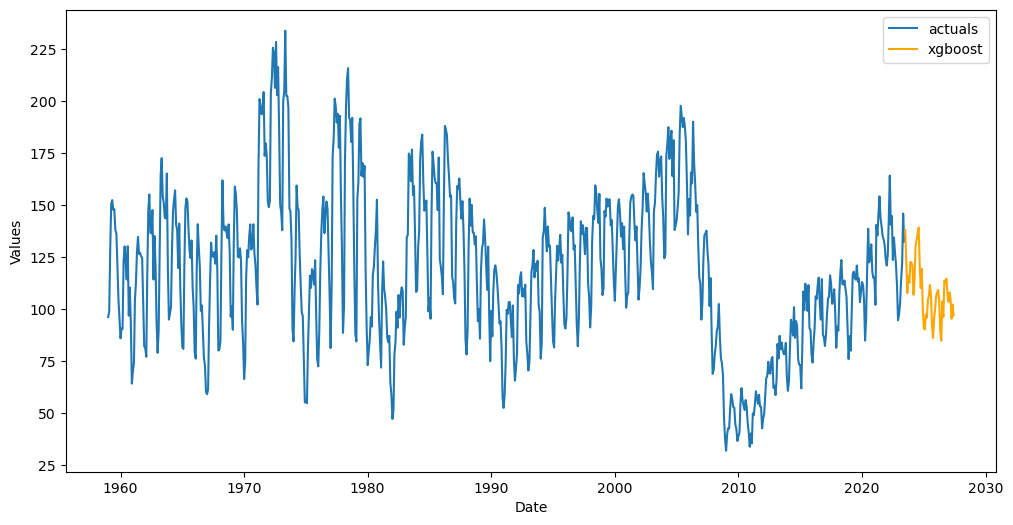

In [12]:
f_new.plot()
plt.show()

### View the in-sample predictions

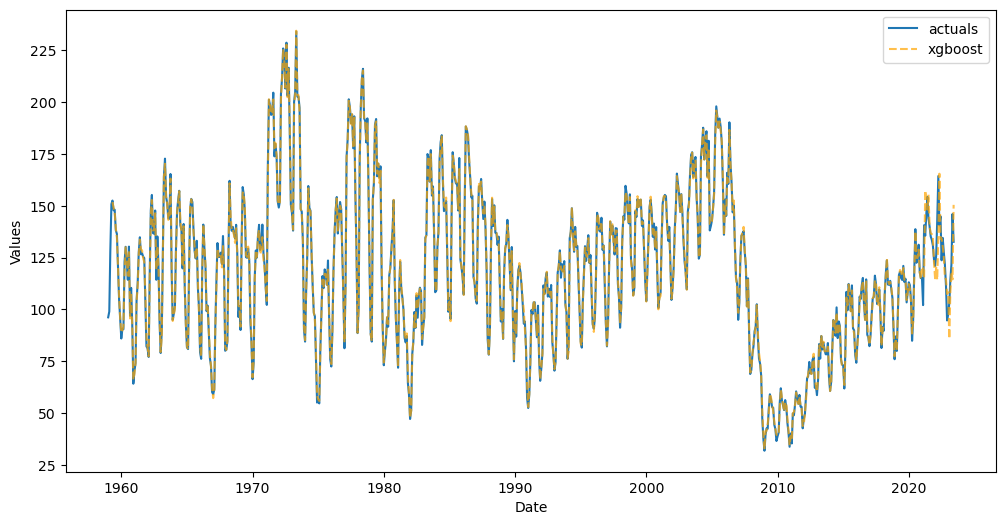

In [13]:
f_new.plot_fitted()
plt.show()

In the below plot, the model has seen all observations until December, 2020. From January, 2021 through June, 2023, it is seeing those observations for the first time, but because it has the actual y observations, its predictions are expected to be more accurate than the forecast into the unknown horizon.

## Predict over a specific date range
- Instead of storing the model info into the new `Forecaster` object, you can instead get predicted output over a specific date range.

In [14]:
preds = f_new.transfer_predict(
    transfer_from = f,
    model = 'xgboost',
    dates = pd.date_range(start='2021-01-01',end='2023-12-31',freq='MS'),
    save_to_history=False,
    return_series=True,
)
preds

2021-01-01    120.414276
2021-02-01    120.495262
2021-03-01    115.237289
2021-04-01    157.336044
2021-05-01    153.519592
2021-06-01    148.156540
2021-07-01    155.455841
2021-08-01    140.149063
2021-09-01    136.719086
2021-10-01    136.396225
2021-11-01    134.729935
2021-12-01    122.803619
2022-01-01    115.014137
2022-02-01    120.187630
2022-03-01    114.294334
2022-04-01    135.624725
2022-05-01    165.435593
2022-06-01    133.902603
2022-07-01    134.251709
2022-08-01    130.484985
2022-09-01    125.146767
2022-10-01    115.346245
2022-11-01    114.462318
2022-12-01    107.456902
2023-01-01    108.279457
2023-02-01     85.891899
2023-03-01    107.956871
2023-04-01    118.046204
2023-05-01    114.491058
2023-06-01    150.420700
2023-07-01    138.233521
2023-08-01    123.780426
2023-09-01    107.738792
2023-10-01    115.907219
2023-11-01    112.723907
2023-12-01    122.730095
dtype: float32

From January  through June, 2021, the predictions are considered in-sample, although the model has never previously seen them (it predicted using the actual y observations over that timespan, and that is a form of leakage for auto-regressive time series models). The rest of the predictions are truly out-of-sample.

## Transfer Predict in a Pipeline
- We can use auto-transformation selection and pipelines to apply predictions from a fitted model into a new Forecaster object. This can be good to apply when new data frequently comes through and you don't want to refit models.

### Find optimal set of transformations

In [15]:
transformer, reverter = find_optimal_transformation(f,verbose=True)

Using xgboost model to find the best transformation set on 1 test sets, each 24 in length.
All transformation tries will be evaluated with 12 lags.
Last transformer tried:
[]
Score (rmse): 20.58674859410421
--------------------------------------------------
Last transformer tried:
[('DetrendTransform', {'loess': True})]
Score (rmse): 16.0610904656786
--------------------------------------------------
Last transformer tried:
[('DetrendTransform', {'poly_order': 1})]
Score (rmse): 17.966964748692096
--------------------------------------------------
Last transformer tried:
[('DetrendTransform', {'poly_order': 2})]
Score (rmse): 16.12300215198315
--------------------------------------------------
Last transformer tried:
[('DetrendTransform', {'loess': True}), ('DeseasonTransform', {'m': 12, 'model': 'add'})]
Score (rmse): 20.748404440789933
--------------------------------------------------
Last transformer tried:
[('DetrendTransform', {'loess': True}), ('DiffTransform', 1)]
Score (rmse):

### Fit the first pipeline

In [16]:
def forecaster(f):
    f.auto_Xvar_select()
    f.ingest_grid('xgboost')
    f.limit_grid_size(10)
    f.cross_validate(k=3,test_length=48)
    f.auto_forecast()

In [17]:
pipeline = Pipeline(
    steps = [
        ('Transform',transformer),
        ('Forecast',forecaster),
        ('Revert',reverter),
    ]
)

f = pipeline.fit_predict(f)

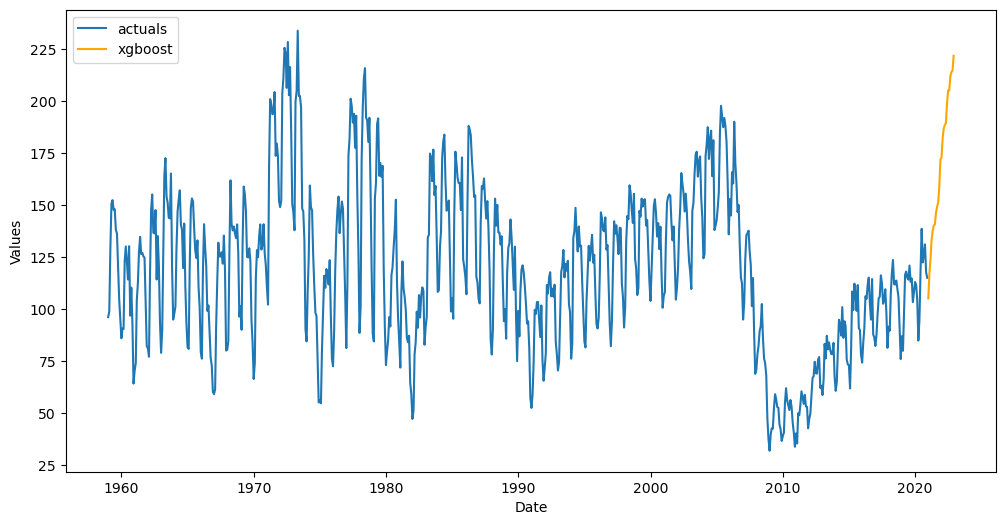

In [18]:
f.plot()
plt.show()

### Predict new data

In [19]:
def transfer_forecast(f,transfer_from):
    infer_apply_Xvar_selection(infer_from=transfer_from,apply_to=f)
    f.transfer_predict(transfer_from=transfer_from,model='xgboost')

In [20]:
pipeline_new = Pipeline(
    steps = [
        ('Transform',transformer),
        ('Transfer Forecast',transfer_forecast),
        ('Revert',reverter),
    ]
)

f_new = pipeline_new.fit_predict(f_new,transfer_from=f) # even though it says fit, no model actually gets fit in the pipeline

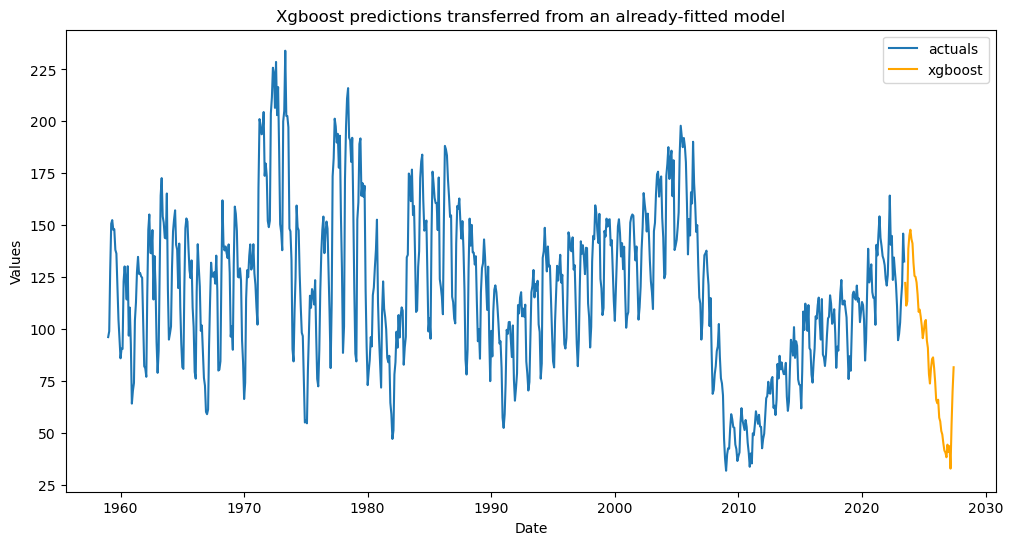

In [21]:
f_new.plot()
plt.title('Xgboost predictions transferred from an already-fitted model') 
plt.show()

In [22]:
f_new

Forecaster(
    DateStartActuals=1959-01-01T00:00:00.000000000
    DateEndActuals=2023-06-01T00:00:00.000000000
    Freq=MS
    N_actuals=774
    ForecastLength=48
    Xvars=['AR1', 'AR2', 'AR3', 'AR4']
    TestLength=0
    ValidationMetric=rmse
    ForecastsEvaluated=['xgboost']
    CILevel=None
    CurrentEstimator=mlr
    GridsFile=Grids
)